In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

books = pd.read_excel(r"C:\Users\rtekem\OneDrive - Vishay Intertechnology, Inc\Desktop\Machine_Learning_project\IMPUT\Recommendation\BX-Books.xlsx")
users = pd.read_excel(r"C:\Users\rtekem\OneDrive - Vishay Intertechnology, Inc\Desktop\Machine_Learning_project\IMPUT\Recommendation\BX-Users.xlsx")
ratings = pd.read_excel(r"C:\Users\rtekem\OneDrive - Vishay Intertechnology, Inc\Desktop\Machine_Learning_project\IMPUT\Recommendation\BX-Book-Ratings.xlsx")


# PIVOT ITEM/USER

In [217]:
# Supprimer les colonnes inutiles
books = books.drop(columns=['Unnamed: 8', 'Unnamed: 9'])

# Renommer les colonnes correctement
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher',
                 'imageUrlS', 'imageUrlM', 'imageUrlL']

users.columns = ['userID', 'Location', 'Age']
ratings.columns = ['userID', 'ISBN', 'bookRating']

In [218]:
books.shape,users.shape,ratings.shape

((61056, 8), (278858, 3), (174003, 3))

In [219]:
print(ratings.shape)
print(list(ratings.columns))

(174003, 3)
['userID', 'ISBN', 'bookRating']


In [220]:
books.head(3)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [221]:
users.head(3)

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.000
2,3,"moscow, yukon territory, russia",NaN


In [222]:
ratings.head(3)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0


In [223]:
ratings['bookRating'].value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         5
2         0
3         3
4         6
         ..
173998    8
173999    9
174000    0
174001    8
174002    0
Name: bookRating, Length: 174003, dtype: int64>

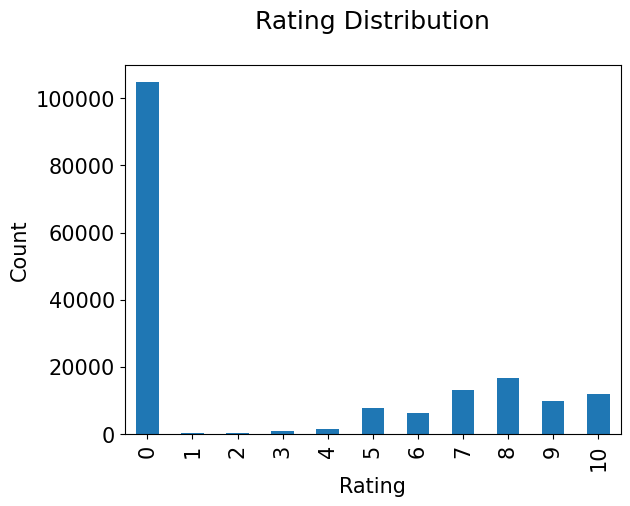

In [224]:
plt.rc("font", size=15)

# Compter les valeurs et les trier par index croissant (par note)
rating_counts = ratings.bookRating.value_counts().sort_index()

# Tracer le graphique
rating_counts.plot(kind='bar')

# Ajout des titres et labels
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')

# Sauvegarder et afficher
plt.savefig('system1.png', bbox_inches='tight')
plt.show()


In [225]:
print(books.shape)
print(list(books.columns))

(61056, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [226]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


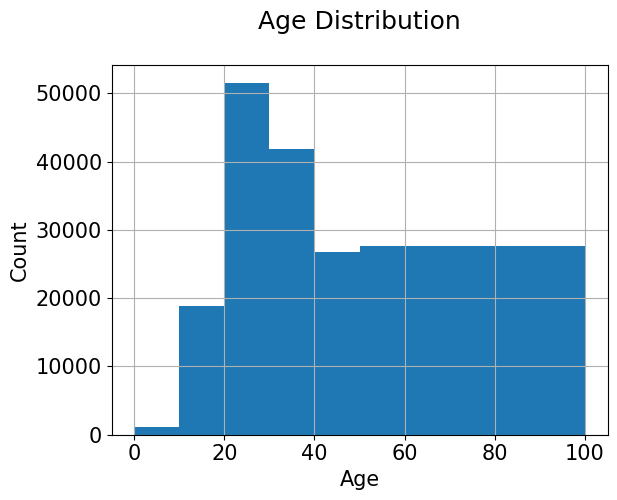

In [227]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [229]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

Collaborative Filtering Using k-Nearest Neighbors (kNN)

kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user,


In [111]:
books.columns

Index(['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher',
       'imageUrlS', 'imageUrlM', 'imageUrlL'],
      dtype='object')

In [113]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,277427,30615321,0,"Ask for May, Settle for June (A Doonesbury book)"
2,277427,60002050,0,On a Wicked Dawn (Cynster Novels)
3,277427,60192704,0,"Beauty Fades, Dumb Is Forever: The Making of a..."
4,277427,60542128,7,When the Storm Breaks


In [115]:
combine_book_rating.isna().sum()

userID        0
ISBN          0
bookRating    0
bookTitle     0
dtype: int64

In [117]:
combine_book_rating = combine_book_rating.dropna(axis=0, subset=['bookTitle'])

combine_book_rating['bookTitle'] = combine_book_rating['bookTitle'].astype(str)

book_ratingCount = (
    combine_book_rating
    .groupby(by='bookTitle')['bookRating']
    .count()
    .reset_index()
    .rename(columns={'bookRating': 'totalRatingCount'})
    [['bookTitle', 'totalRatingCount']]
)

book_ratingCount.head()


,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,1
1,Beyond IBM: Leadership Marketing and Finance ...,1
2,Earth Prayers From around the World: 365 Pray...,1
3,Final Fantasy Anthology: Official Strategy Gu...,2
4,It Takes Two,1


We combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books

In [120]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,13
1,277427,30615321,0,"Ask for May, Settle for June (A Doonesbury book)",1
2,277427,60002050,0,On a Wicked Dawn (Cynster Novels),1
3,277427,60192704,0,"Beauty Fades, Dumb Is Forever: The Making of a...",3
4,277427,60542128,7,When the Storm Breaks,6


In [122]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   32281.000
mean        1.863
std         2.300
min         1.000
25%         1.000
50%         1.000
75%         2.000
max        47.000
Name: totalRatingCount, dtype: float64


In [124]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    3.000
0.910    4.000
0.920    4.000
0.930    4.000
0.940    5.000
0.950    5.000
0.960    6.000
0.970    7.000
0.980    9.000
0.990   12.000
Name: totalRatingCount, dtype: float64


Cela veut dire que pour être dans le top 10 % des livres les plus notés, il faut au minimum 3.000 notes, et pour le top 1 %, au moins 12.000 notes.

In [132]:
rating_with_totalRatingCount.shape

(60140, 5)

In [138]:
popularity_threshold = 5
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,13
4,277427,60542128,7,When the Storm Breaks,6
5,277427,60913509,0,In Country RI,5
6,277427,006092988X,0,A Tree Grows in Brooklyn,7
7,277427,60930535,0,The Poisonwood Bible: A Novel,20


In [140]:
rating_popular_book.shape

(17607, 5)

Filter to users in US and Canada only

In [143]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,13,"gilbert, arizona, usa"
1,277427,60542128,7,When the Storm Breaks,6,"gilbert, arizona, usa"
2,277427,60913509,0,In Country RI,5,"gilbert, arizona, usa"
3,277427,006092988X,0,A Tree Grows in Brooklyn,7,"gilbert, arizona, usa"
4,277427,60930535,0,The Poisonwood Bible: A Novel,20,"gilbert, arizona, usa"


In [145]:
us_canada_user_rating.shape

(14651, 6)

Cosine Similarity

In [148]:
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])

In [150]:
us_canada_user_rating.shape

(14225, 6)

In [152]:
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)

In [154]:
us_canada_user_rating_pivot.head()

userID,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,35859,36554,36606,36609,36836,36907,37712,277427,277639,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
101 Dalmatians,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"14,000 Things to Be Happy About",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1984,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1st to Die: A Novel,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,7.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2010: Odyssey Two,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [156]:
from scipy.sparse import csr_matrix

us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [160]:
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [169]:

query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

1530


In [171]:
us_canada_user_rating_pivot.index[query_index]

'The First Counsel'

In [173]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The First Counsel:

1: Plantation: A Lowcountry Tale, with distance of 0.0:
2: The Overseer, with distance of 0.0:
3: The First Counsel, with distance of 0.0:
4: The Simple Truth, with distance of 0.0:
5: Primal Fear, with distance of 0.0:


# PIVOT USER/ITEM

In [243]:
print(ratings.shape)
print(list(ratings.columns))

(84491, 3)
['userID', 'ISBN', 'bookRating']


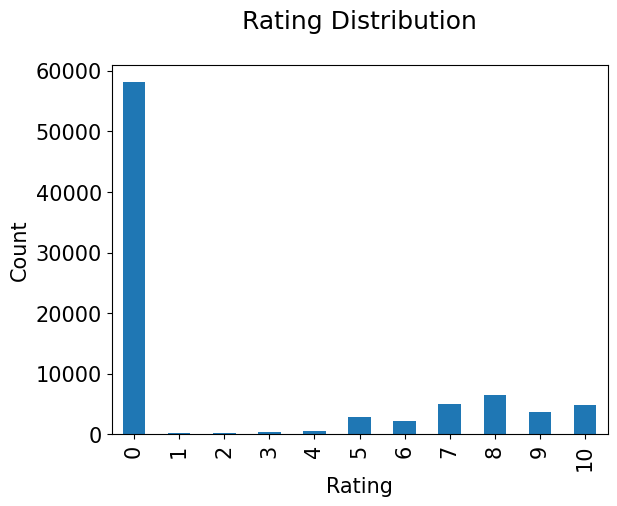

In [245]:
plt.rc("font", size=15)

# Compter les valeurs et les trier par index croissant (par note)
rating_counts = ratings.bookRating.value_counts().sort_index()

# Tracer le graphique
rating_counts.plot(kind='bar')

# Ajout des titres et labels
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')

# Sauvegarder et afficher
plt.savefig('system1.png', bbox_inches='tight')
plt.show()


In [247]:
print(books.shape)
print(list(books.columns))

(61056, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [249]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


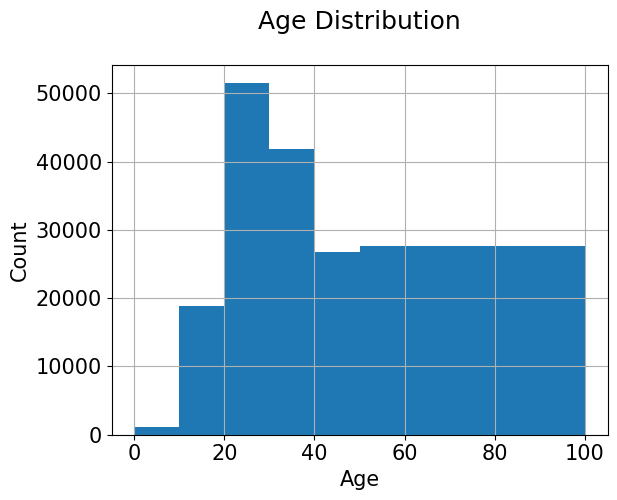

In [251]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

Recommendation Based on Rating Counts

In [254]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
rating_count.sort_values('bookRating', ascending=False).head()

,bookRating
ISBN,
971880107,47
60928336,37
067976402X,35
440214041,35
375727345,32


In [256]:
most_rated_books = pd.DataFrame(['971880107', '60928336', '067976402X', '440214041', '375727345'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...


Recommendations based on correlations

We use Pearsons’R correlation coefficient to measure the linear correlation between two variables, in our case, the ratings for two books.

First, we need to find out the average rating, and the number of ratings each book received.

In [261]:
average_rating = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
971880107,0.468,47
60928336,2.000,37
067976402X,2.486,35
440214041,1.914,35
375727345,2.281,32


bookRating	ratingCount
ISBN		
0971880107	1.019584	2502
0316666343	4.468726	1295
0385504209	4.652322	883
0060928336	3.448087	732
0312195516	4.334716	723


Observations: In this data set, the book that received the most rating counts was not highly rated at all. As a result, if we were to use recommendations based on rating counts, we would definitely make mistakes here. So, we need to have a better system.

### To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [267]:
counts1 = ratings['userID'].value_counts()
counts1

userID
11676     13602
35859      5850
278418     4533
16795      2948
36836      2529
          ...  
33145       202
28634       201
9856        201
36554       200
26883       200
Name: count, Length: 118, dtype: int64

In [271]:
counts = ratings['bookRating'].value_counts()
counts

bookRating
0     58135
8      6490
7      5053
10     4824
9      3693
5      2827
6      2189
4       543
3       348
1       199
2       190
Name: count, dtype: int64

In [273]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

Rating matrix

We convert the ratings table to a 2D matrix. The matrix will be sparse because not every user rated every book.

In [278]:
# Supprimer les doublons : 1 seule note par userID/ISBN
ratings = ratings.drop_duplicates(subset=['userID', 'ISBN'])

ratings_pivot = ratings.pivot(index='userID', columns='ISBN').bookRating
userID = ratings_pivot.index
ISBN = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(118, 57903)


ISBN,0,222318,276022,610524,639292,651415,652320,1046438,1047213,1047973,...,O77O428452,O805063196,O889950962,O9088446X,Q380708353,TBR0385495641,X000000000,ZR903CX0003,"\0432534220\""""","\2842053052\"""""
userID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [290]:
bones_ratings = ratings_pivot['067976402X']
similar_to_bones = ratings_pivot.corrwith(bones_ratings)
corr_bones = pd.DataFrame(similar_to_bones, columns=['pearsonR'])
corr_bones.dropna(inplace=True)
corr_summary = corr_bones.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=30].sort_values('pearsonR', ascending=False).head(10)

C:\Users\rtekem\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\rtekem\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\rtekem\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\rtekem\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\rtekem\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,pearsonR,ratingCount
ISBN,,
067976402X,1.000,35
316666343,0.404,31
375727345,0.253,32
971880107,0.205,47
385504209,0.035,31
60928336,0.012,37
440214041,-0.263,35


We obtained the books’ ISBNs, but we need to find out the titles of the books to see whether they make sense.

In [297]:
import pandas as pd
import numpy as np

# Liste des ISBN similaires à un livre donné (ex : Bones)
isbn_similaires = ['316666343', '375727345', '971880107', '385504209', '60928336', '440214041']

# Création du DataFrame avec le bon nombre d’index (6)
books_corr_to_bones = pd.DataFrame(isbn_similaires, columns=['ISBN'])

# Fusion avec la table des livres
corr_books = pd.merge(books_corr_to_bones, books, on='ISBN')

# Affichage
print(corr_books)


Empty DataFrame
Columns: [ISBN, bookTitle, bookAuthor, yearOfPublication, publisher, imageUrlS, imageUrlM, imageUrlL]
Index: []
